In [1]:
import tensorflow as tf

print(tf.__version__)
print(tf.test.is_gpu_available())

2.0.0
True


### Transformer 模型的核心思想是自注意力机制（self-attention）
能注意输入序列的不同位置以计算该序列的表示的能力。Transformer 创建了多层自注意力层（self-attetion layers）组成的堆栈，下文的按比缩放的点积注意力（Scaled dot product attention）和多头注意力（Multi-head attention）部分对此进行了说明。

一个 transformer 模型用自注意力层而非 RNNs 或 CNNs 来处理变长的输入。
`这种通用架构有一系列的优势：`

1、它不对数据间的时间/空间关系做任何假设。这是处理一组对象（objects）的理想选择（例如，星际争霸单位（StarCraft units））。
2、层输出可以并行计算，而非像 RNN 这样的序列计算。
3、远距离项可以影响彼此的输出，而无需经过许多 RNN 步骤或卷积层（例如，参见场景记忆 Transformer（Scene Memory Transformer））
它能学习长距离的依赖。在许多序列任务中，这是一项挑战。

`该架构的缺点是：`

1、对于时间序列，一个单位时间的输出是从整个历史记录计算的，而非仅从输入和当前的隐含状态计算得到。这可能效率较低。
2、如果输入确实有时间/空间的关系，像文本，则必须加入一些`位置编码`，否则模型将有效地看到一堆单词。

#### 重点
1、位置向量编码的含义

2、和seq2seq的区别

3、Q,K,V的设计（QKV图形）

4、从attention谈transformer本质

### 以下代码用来实现经典的编码器－解码器代码，并使用 cmn_eng　2.2w条中英文翻译数据，作为实例
如果希望更详细的解读，强烈推荐阅读：https://zhuanlan.zhihu.com/p/28054589
https://leovan.me/cn/2018/10/seq2seq-and-attention-machanism/

In [2]:
import tensorflow as tf
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

# 修复中文显示问题
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
print(tf.__version__)

# 判断是否gpu可用,如果可用设置gpu使用显存
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

2.0.0


In [4]:
import unicodedata
import re
import numpy as np
import os
import io
import time

In [5]:
with open('./data/ch_en.txt', 'r', encoding='utf-8') as f:
    contexts = f.readlines()
contexts[10]

'I met Lao Wang as soon as I went out of the door.\t我一出门就碰上老王了。\n'

In [6]:
def data_pro(contexts):
    processed_contexts_en = []
    processed_contexts_ch = []
    for line in contexts:
        en, ch = re.split(r'\t', line.strip(), 1)
        # 如果句子过长，则跳过此句
#         if len(ch) > 100:
#             continue
#         print(en, ch)
        en = re.sub(r'([\?\.\!\,¿])', r' \1', en)
#         print(en)
        en = re.sub(r'\s+', ' ', en)
        ch = re.sub(r'\s+', ' ', ch)
        en = re.sub(r'[^a-zA-Z\?\.\!\,。？！，、¿]+', r' ', en)
        ch = re.sub(r'[^a-zA-Z\?\.\!\,。？！，、¿\u4e00-\u9fa5]+', r' ', ch)
        en = '<start> ' + en[:200] + ' <end>'
        ch = '<start> ' + ' '.join([i for i in ch[:100]]) + ' <end>'
        
        processed_contexts_en.append(en)
        processed_contexts_ch.append(ch)
    
    return processed_contexts_en, processed_contexts_ch


processed_contexts_en, processed_contexts_ch = data_pro(contexts)

In [7]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [8]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(30000,
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [9]:
def load_dataset():
    # 创建清理过的输入输出对
    input_tensor, inp_lang_tokenizer = tokenize(processed_contexts_en)
    target_tensor, targ_lang_tokenizer = tokenize(processed_contexts_ch)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [10]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset()
input_tensor[-1], target_tensor[-1]
print('inp_lang词典大小', len(inp_lang.index_word))
inp_lang.texts_to_sequences(['<start> hello world <end>', 'head of'])
targ_lang.texts_to_sequences(['<start> 你 好 世 界 <end>', '你 好']), targ_lang.index_word[1]

inp_lang词典大小 105877


([[3, 19, 90, 249, 296, 4], [19, 90]], '的')

In [11]:
# 计算目标张量的最大长度 （max_length）
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [12]:
# 采用 80 - 20 的比例切分训练集和验证集
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.15)

# 显示长度
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

255000 255000 45001 45001


In [13]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [14]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
3 ----> <start>
96 ----> how
58 ----> do
15 ----> you
3013 ----> replace
1 ----> the
40 ----> all
3146 ----> singing
5 ----> ,
40 ----> all
2679 ----> dancing
116 ----> man
2469 ----> alive
20 ----> as
19890 ----> oscars
1829 ----> host
48 ----> ?
4 ----> <end>

Target Language; index to word mapping
3 ----> <start>
19 ----> 你
51 ----> 如
211 ----> 何
299 ----> 取
228 ----> 代
6 ----> 一
16 ----> 个
32 ----> 能
883 ----> 歌
793 ----> 善
886 ----> 舞
1 ----> 的
150 ----> 全
238 ----> 球
106 ----> 最
76 ----> 性
204 ----> 感
542 ----> 男
14 ----> 人
25 ----> 来
131 ----> 主
260 ----> 持
757 ----> 奥
189 ----> 斯
597 ----> 卡
237 ----> ？
4 ----> <end>


In [15]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 256
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [16]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch, example_target_batch

(<tf.Tensor: id=18, shape=(256, 53), dtype=int32, numpy=
 array([[    3,  3560,    26, ...,     0,     0,     0],
        [    3,     5,     1, ...,     0,     0,     0],
        [    3, 29049,    53, ...,     0,     0,     0],
        ...,
        [    3,     7,    25, ...,     0,     0,     0],
        [    3,    49,    15, ...,     0,     0,     0],
        [    3,    11,    14, ...,     0,     0,     0]], dtype=int32)>,
 <tf.Tensor: id=19, shape=(256, 61), dtype=int32, numpy=
 array([[  3, 194, 618, ...,   0,   0,   0],
        [  3, 327,  76, ...,   0,   0,   0],
        [  3,  10,  17, ...,   0,   0,   0],
        ...,
        [  3, 324, 383, ...,   0,   0,   0],
        [  3,  91,  19, ...,   0,   0,   0],
        [  3,   7, 554, ...,   0,   0,   0]], dtype=int32)>)

#### self-attention机制的transformer实现:
1、编码器:是由 N=6 个相同的网络层构成，每层中包含两个子层。第一层为一个 Multi-Head Self-Attention 层，第二层为一个 Position-Wise 全链接的前馈神经网络。每一层再应用一个残差连接 (Residual Connection) 7 和一个层标准化 (Layer Normalization) 8。则每一层的输出为 Layer(x + sublayer(x))，其中`sublayer(x)`为子层本身的函数实现。为了实现 为了实现残差连接，模型中所有的子层包括 Embedding 层的输出维度均为 dmodel=512。

２、解码器: 也是由 N=6 个相同的网络层构成，但每层中包含三个子层，增加的第三层用于处理编码器的输出。同编码器一样，每一层应用一个残差连接和一个层标准化。除此之外，解码器对 Self-Attention 层进行了修改，确保对于位置  的预测仅依赖于位置在  之前的输出。

#### 重点的几个部分：
① self_attention层(Multi-head attention)组件, Attention(Q, K, V) = softmax({Q . trans(K) /sqrt(d_k)) V

② feed_forword层组件
如图：
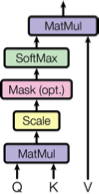

In [17]:
# mask的理解我觉得是 transformer最难的点之一
# 计算mask矩阵，需要注意的是，为了计算 softmax scaled_attention_logits += (mask * -1e9)，mask位置取1，非mask位置取0
def create_padding_mask(seq):
    """
    计算sequence的mask
    """
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    return seq[:, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [18]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: id=27, shape=(3, 1, 5), dtype=float32, numpy=
array([[[0., 0., 1., 1., 0.]],

       [[0., 0., 0., 1., 1.]],

       [[1., 1., 1., 0., 0.]]], dtype=float32)>

In [19]:
# 生成一个下三角矩阵：
tf.linalg.band_part(tf.ones((3,3)), -1, 0)

<tf.Tensor: id=33, shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 1., 0.],
       [1., 1., 1.]], dtype=float32)>

In [20]:
# 创建一个用来解码器训练用的 前瞻遮掩　(look_ahead_mask)，用于遮挡一个序列中的后续标记，因为用来训练时，只能看见前面的序列，看不见后面
def create_look_ahead_mask(size):
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    
    return ahead_mask

In [21]:
create_look_ahead_mask(5)

<tf.Tensor: id=41, shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]], dtype=float32)>

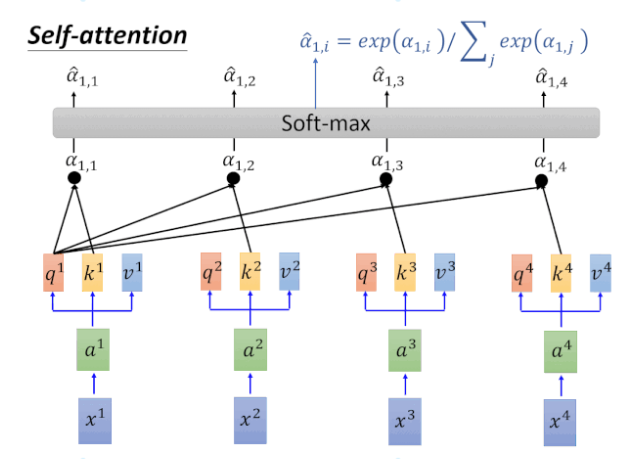

####     q, k, v都是经过计算后的向量，且为了方便后续解码器使用，将q,k,v的seq_len和depth作区分，q@k需要depth_q=depth_k,记作depth
    q: (batch_size, num_heads, seq_len_q, depth)
    k: (batch_size, num_heads, seq_len_k, depth)
    v: (batch_size, num_heads, seq_len_v, depth_v)
    mask: (batch_size, seq_len_q, seq_len_k)


In [22]:
def compute_scaled_dot_product_attention(q, k, v, mask=None):
    """
    q, k, v都是经过计算后的向量，且为了方便后续解码器使用，将q,k,v的seq_len和depth作区分，q@k需要depth_q=depth_k,记作depth
    q: (batch_size, num_heads, seq_len_q, depth)
    k: (batch_size, num_heads, seq_len_k, depth)
    v: (batch_size, num_heads, seq_len_v, depth_v)
    mask: (batch_size, seq_len_q, seq_len_k)
    
    """
    # Q .transpose(K)
    # tf.matmul()中的transpose_b默认从最后两位进行转置(tf.transpose(x, perm=[0,1,3,2]))，即得(batch_size, num_heads, seq_len_q, seq_len_k)
    mat_qk = tf.matmul(q, k, transpose_b=True)
    # sqrt(dk)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)  # depth
    scaled_attention_logits = mat_qk / tf.math.sqrt(dk)    # (batch_size, num_heads, seq_len_q, seq_len_k)
    # 加上mask
    if mask is not None:
        # 先将mask转换 mask: (batch_size, seq_len_q, seq_len_k) --> (batch_size, 1 , seq_len_q, seq_len_k)，然后使用广播机制
        mask = mask[:, tf.newaxis, : , :]
        # 由于后面计算softmax方便，1e0为1，不能起到mask的作用，所以使用 -1e9接近无穷大操作，起到mask作用
        scaled_attention_logits += (mask * -1e9)   # batch_size, num_heads, seq_len_q, seq_len_k

    # 计算权重
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) # batch_size, num_heads, seq_lenq, seq_len_k
    # 计算value: (bz, nh, sql, sql) @ (bz, nh, sql, depth_v) -->　(bz, nh, sql, depth_v)
    output = tf.matmul(attention_weights, v)    # 然后将多个头的output拼接起来
    
    return output, attention_weights

#### 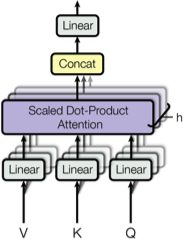

In [23]:
# 定义　MultiHeadAttention:参数: d_model, num_heads
# multi_head_attention输入为 inputs 维度 (batch_size, seq_len, head_out)

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        # 输出维度除以head数应为整数
        assert self.d_model % self.num_heads == 0
        # 单个head的维度 (batch, seq_len, self.depth)
        self.depth = self.d_model // self.num_heads
        
        # 定义Q, K, V注意力矩阵,同时定义多头，然后使用reshape
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        # 线性层
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x):
        """
        x : (batch_size, seq_len, d_model)
        """
        x = tf.reshape(x, [tf.shape(x)[0], -1, self.num_heads, self.depth])
        
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        """这里要把在编码器中，q,k,v是相同的，但是将 q,k,v拆分开写，方便后续解码器使用不同的v, k, q
        """
        q = self.wq(q)    # (batch_size, seq_len, d_model)
        k = self.wk(k)
        v = self.wv(v)
        
        # 拆分成多头
        q = self.split_heads(q)    # (batch_size, num_heads, seq_len, self.depth)
        k = self.split_heads(k)
        v = self.split_heads(v)

        #(bz, nh, sql, sql)
        scaled_attention, attention_weights = compute_scaled_dot_product_attention(q, k, v, mask)
        
        concat_attention = tf.reshape(scaled_attention, (tf.shape(scaled_attention)[0], -1, self.d_model))
        # 经过 linear层
        output = self.dense(concat_attention)    # (batch_size, seq_len, d_model)
        # print(output.shape)

        return output, attention_weights

In [24]:
temp_mha = MultiHeadAttention(num_heads=8, d_model=512)
x = tf.random.uniform((2, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(x, x, x, mask=None)
out, attn = temp_mha(out, out, out, mask=None)
out.shape, attn.shape

(TensorShape([2, 60, 512]), TensorShape([2, 8, 60, 60]))

#### 定义 Feed_Forward前馈神经网络
点式前馈网络由两层全联接层组成，两层之间有一个 ReLU 激活函数。

In [25]:
def point_wise_feed_forward_network(d_model, dff):
    """一个比较奇怪的操作
    """
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

多层transformer的编码器和解码器：
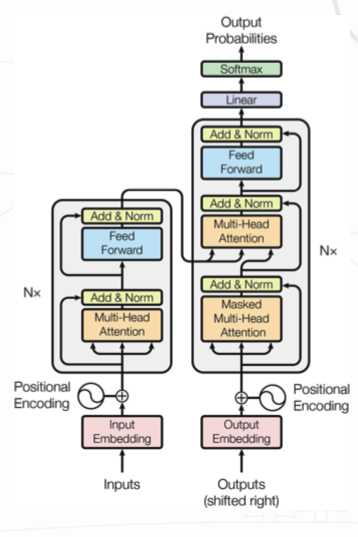
再来回顾一下transformer结构，并没有脱离注意力机制的设计:

1、输入语句经过编码器层，为每个序列生成对应输出序列

2、解码器关注编码器的输出及自身输入预测下一个序列，不同于Luong attention类型，由于非递归式的，所以使用下三角mask遮掩后面的词)

3、基于transformer的设计，q应该来源于解码器,k,v来源与编码器，这种和seq2seq-attention如出一辙，相当统一

4、由于使用了self_attention做并行计算，那么mask设计成(batch_size, seq_len_encoder, seq_len_decoder)，且解码器需要一个下三角矩阵来做mask

### 编码器层（Encoder layer）
每个编码器层包括以下子层：

1、多头注意力（有填充遮挡）

2、点式前馈网络（Point wise feed forward networks）。

In [26]:
class EncoderLayer(tf.keras.layers.Layer):
    """定义一个单层的encoder组件
    1、包含多头注意力
    2、包含Feed_Forward
    3、残差链接并层归一化 LayerNorm(x + Sublayer(x))
    4、dropout层
    """
    def __init__(self, d_model, num_heads, intermediate_size, rate=0.1):
        super(EncoderLayer, self).__init__()
        # 点式前馈网络
        self.feed_forward = point_wise_feed_forward_network(d_model, intermediate_size)
        # 多头注意力
        self.multi_head_att = MultiHeadAttention(d_model, num_heads)
        # layer_normalization
        self.layernorm1 = tf.keras.layers.LayerNormalization(axis=-1, epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(axis=-1, epsilon=1e-6)
        # dropout
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        """
        输入：(batch_size, input_seq_len, d_model)
        输出: (batch_size, input_seq_len, d_model)
        """
        # 多头注意力
        multi_head_att, _ = self.multi_head_att(x, x, x, mask)   # (batch_size, input_seq_len, d_model)
        # dropout层
        #tf.print('multi_head_att:', multi_head_att.shape)
        dropout1 = self.dropout1(multi_head_att, training=training)   # (batch_size, input_seq_len, d_model)
        # layer_norm层: LayerNorm(x + Sublayer(x))
        layer_norm1 = self.layernorm1(x + dropout1)   # (batch_size, input_seq_len, d_model)
        # feed_forward
        feed_forward = self.feed_forward(layer_norm1)
        # dropout2
        dropout2 = self.dropout2(feed_forward, training=training)
        # layer_norm2
        out = self.layernorm2(layer_norm1 + dropout2)
        
        return out

In [27]:
#测试一下
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### 解码器层：Decoder layer

每个解码器层包括以下子层：

1、遮掩的多头注意力(前瞻遮掩和填充遮掩两种)

2、多头注意力（用填充遮挡）。V（数值）和 K（主键）接收编码器输出作为输入。Q（请求）接收遮挡的多头注意力子层的输出。

3、点式前馈网络

In [28]:
class DecoderLayer(tf.keras.layers.Layer):
    """解码器
    解码器与编码器略有不同，总共有两层多头注意力层，且第二层的k,v来自编码器
    """
    def __init__(self, d_model, num_heads, intermediate_size, rate=0.1):
        super(DecoderLayer, self).__init__()
        # 两层多头注意力层
        self.multi_head_att1 = MultiHeadAttention(d_model, num_heads)
        self.multi_head_att2 = MultiHeadAttention(d_model, num_heads)
        
        # 点式前馈网络
        self.feed_forward = point_wise_feed_forward_network(d_model, intermediate_size)
        
        # layer_normalization
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        # dropout层
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        x: 解码器输入
        enc_outputc: 编码器输出
        traininga: 是否训练阶段
        look_ahead_mask: 解码器中使用的后向遮掩
        padding_mask: padding_mask
        """
        # 计算第一层att，使用 look_ahead_mask
        dec_mth1, dec_att_weight1 = self.multi_head_att1(x, x, x, look_ahead_mask)
        dec_dropout1 = self.dropout1(dec_mth1, training=training)
        dec_layernorm1 = self.layernorm1(x + dec_dropout1)
        # 计算第二层att，q为第一层输出，k,v为编码器输出
        dec_mth2, dec_att_weight2 = self.multi_head_att2(enc_output, enc_output, dec_layernorm1, padding_mask)
        dec_dropout2 = self.dropout2(dec_mth2, training=training)
        dec_layernorm2 = self.layernorm2(dec_layernorm1 + dec_dropout2)
        # 计算点式前馈
        dec_ff = self.feed_forward(dec_layernorm2)
        dec_dropout3 = self.dropout3(dec_ff, training=training)
        out = self.layernorm3(dec_layernorm2 + dec_dropout3)
        
        return out, dec_att_weight1, dec_att_weight2

In [29]:
# 测试一下
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

#### 编码器（Encoder）:
    1、输入嵌入 (input embedding)
    2、位置编码 (Position encodding)
    3、N个编码器层
Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})};

Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})}

这样做有两个好处：

1、范围处于0-1

2、相邻位置和远距离位置向量在向量距离上也有对应大小

In [30]:
# 相对位置编码函数
def get_angles(pos, i, d_model):
    """计算 pos / 10000^{2i / d_{model}
    """
#     print(pos.shape)    # (50, 1)
#     print(i) # list 0-d_model
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def position_embedding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # 将 sin 应用于数组中的偶数索引（indices）；2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # 将 cos 应用于数组中的奇数索引；2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


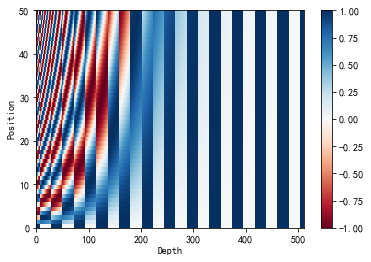

In [31]:
pos_encoding = position_embedding(50, 512)    # 以512维编码50长度的位置向量
print (pos_encoding.shape)
# print(pos_encoding[0])
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [32]:
class Encoder(tf.keras.layers.Layer):
    """多层编码器堆叠
    """
    def __init__(self, num_layers, d_model, num_heads, intermediate_size, input_vocab_size, 
                 maximum_position_encoding, rate=0.1):
        """
        num_layers: encoder_layer层数
        d_model: encoder输出维度, 也是每层encoder_layer输出维度
        num_heads: attention头的个数，也可以看成通道数
        intermediate_sizee: 点式前馈网络feed_forward中dense转换维度
        input_vocab_size: 词表大小
        maximum_position_encoding: 最大位置编码
        rate: Dropout学习率
        """
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        
        # 添加 embedding层
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        # 位置 embedding层
        self.position_embedding = position_embedding(maximum_position_encoding, self.d_model)
        # N层编码器层
        self.enc_layers = [EncoderLayer(d_model, num_heads, intermediate_size, rate) for i in range(num_layers)]
        # Dropout层
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        """x : (batch_size, seq_len)
        """
        # 获取批次最大长度
        seq_len = tf.shape(x)[1]
        # 将嵌入和位置编码相加
        x = self.embedding(x)    # (batch_size, seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))    # 主要是为了减小弱化pos_embedding的影响
        # 取seq_len长度的position_embedding，然后add
        x += self.position_embedding[: , :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        # 加载 encoder_layer
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x

In [33]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         intermediate_size=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)

sample_encoder_output = sample_encoder(tf.random.uniform((64, 100)), 
                                       training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 100, 512)


In [34]:
class Decoder(tf.keras.layers.Layer):
    """解码器和编码器略有不同
    """
    def __init__(self, num_layers, d_model, num_heads, intermediate_size, target_vocab_size, 
                 maximum_position_encoding, rate=0.1):
        """
        num_layers: decoder_layer层数
        d_model: decoder输出维度, 也是每层decoder_layer输出维度
        num_heads: attention头的个数，也可以看成通道数
        intermediate_sizee: 点式前馈网络feed_forward中dense转换维度
        target_vocab_size: 词表大小
        maximum_position_encoding: 最大位置编码
        rate: Dropout学习率
        """
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        
        # 添加 embedding层
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        # 位置 embedding层
        self.position_embedding = position_embedding(maximum_position_encoding, self.d_model)
        # N层编码器层
        self.dec_layers = [DecoderLayer(d_model, num_heads, intermediate_size, rate) for i in range(num_layers)]
        # Dropout层
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # 获取批次最大长度
        seq_len = tf.shape(x)[1]
        # 记录attention_weights
        att_weights = {}
        
        x = self.embedding(x)    # (batch_size, seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.position_embedding[: , :seq_len, :]
        x = self.dropout(x, training)
        # 解码器层: 输入：x, enc_output, training, look_ahead_mask, padding_mask
        # 解码器层输出： out, dec_att_weight1, dec_att_weight2
        for i in range(self.num_layers):
            # 每层 enc_output都是encoder的输出，没有变
            x, dec_att_weight1, dec_att_weight2 = self.dec_layers[i](x, enc_output, training, 
                                                                     look_ahead_mask, padding_mask)
            att_weights['decoder_layer{}_block1'.format(i+1)] = dec_att_weight1 # 形状为:(bz,num_heads,s1l_q,sql_k)
            att_weights['decoder_layer{}_block2'.format(i+1)] = dec_att_weight2 # 形状为:(bz,num_heads,s1l_q,sql_k)
        
        return x, att_weights

In [35]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                        intermediate_size=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)

output, attn = sample_decoder(tf.random.uniform((64, 26)), 
                              enc_output=sample_encoder_output, 
                              training=False, look_ahead_mask=None, 
                              padding_mask=None)

# 注意这两个的输出区别: block1_weight是 decoder端的自注意力weight
print(attn['decoder_layer1_block1'][0][0].shape)
print(attn['decoder_layer1_block1'][0][0][0])
# block1_weight是 decoder是 decoder_q, encoder_k, encoder_v
print(attn['decoder_layer1_block2'][0][1].shape)
output.shape, attn['decoder_layer2_block2'].shape

(26, 26)
tf.Tensor(
[0.02495936 0.02574826 0.03195338 0.04221122 0.05034498 0.05064841
 0.04675838 0.04656952 0.05509788 0.07284845 0.08965264 0.08671387
 0.06405354 0.04123347 0.02814719 0.02317428 0.02290746 0.02462459
 0.02609171 0.02637743 0.02597922 0.0252564  0.02342509 0.01962921
 0.01476692 0.01082718], shape=(26,), dtype=float32)
(26, 100)


(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 100]))

### 创建 Transformer
1、len接编码器、解码器

2、输出使用过线性层

In [36]:
class Transformer(tf.keras.Model):
    """Transformer实现
    """
    def __init__(self,num_layers, d_model, num_heads, intermediate_size, input_vocab_size,
                 target_vocab_size, en_max_pos_encoding, de_max_pos_encoding, rate=0.1):
        """
        num_layers: decoder_layer层数
        d_model: decoder输出维度, 也是每层decoder_layer输出维度
        num_heads: attention头的个数，也可以看成通道数
        intermediate_sizee: 点式前馈网络feed_forward中dense转换维度
        input_vocab_size: 词表大小
        target_vocab_size: 输出词表大小
        en_max_pos_encoding: encoder最大位置编码
        de_max_pos_encoding：decoder最大位置编码
        rate: Dropout学习率
        """
        super(Transformer,self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, intermediate_size, 
                               input_vocab_size, en_max_pos_encoding, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, intermediate_size, 
                               input_vocab_size, de_max_pos_encoding, rate)
        # 输出线性层
        self.final_linear = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_linear(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [37]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, intermediate_size=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    en_max_pos_encoding=10000, de_max_pos_encoding=6000)

temp_input = tf.random.uniform((64, 62))
temp_target = tf.random.uniform((64, 26))

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)
print([l.name for l in sample_transformer.layers])

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

['encoder_1', 'decoder_1', 'dense_84']


TensorShape([64, 26, 8000])

In [38]:
# 配置超参数
num_layers = 4
d_model = 128
intermediate_size = 512
num_heads = 8
input_vocab_size = vocab_inp_size
target_vocab_size = input_vocab_size
dropout_rate = 0.1

In [39]:
# 定义优化器,设置学习率调度
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        # tf.math.rsqrt即平方根的倒数
        arg1 = tf.math.rsqrt(step)
        # **表示指数 a**b = a^b
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

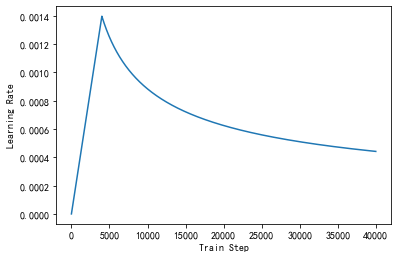

In [40]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [41]:
# 设置动态学习率
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

### 定义损失函数

In [42]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    # 计算mask
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

# loss的计算方式

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

### 训练和检查点

In [43]:
def create_masks(inp, tar):
    # 编码器输入填充
    enc_padding_mask = create_padding_mask(inp)
    
    # 解码器中的第二个注意力模块使用，该填充用于遮挡编码器的输出
    dec_padding_mask = create_padding_mask(inp)
    
    # 在解码器的第一个注意力模块使用，用于填充和遮掩解码器的输入的后续future tokens
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])  # 形状为: seq_len_q * seq_len_q
    dec_target_padding_mask = create_padding_mask(tar)  # 四维  batch_s, 1, 1, seq_len_q
    # tf.maximum支持广播机制
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    
    return enc_padding_mask, combined_mask, dec_padding_mask

In [44]:
inp1 = tf.constant([[1,2,3,4,0],[1,2,3,6,0],[1,2,0,0,0]], dtype=tf.int64)
print(inp1)
inp2 = tf.constant([[1,2,3,4,8,8,8,0,0],[1,2,3,4,8,0,8,0,0],[1,2,3,4,0,0,0,0,0]], dtype=tf.int64)
print(inp2)
enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp1, inp2)
print('enc_padding_mask:', enc_padding_mask)
print('combined_mask: ', combined_mask)
print('dec_padding_mask: ', dec_padding_mask)

tf.Tensor(
[[1 2 3 4 0]
 [1 2 3 6 0]
 [1 2 0 0 0]], shape=(3, 5), dtype=int64)
tf.Tensor(
[[1 2 3 4 8 8 8 0 0]
 [1 2 3 4 8 0 8 0 0]
 [1 2 3 4 0 0 0 0 0]], shape=(3, 9), dtype=int64)
enc_padding_mask: tf.Tensor(
[[[0. 0. 0. 0. 1.]]

 [[0. 0. 0. 0. 1.]]

 [[0. 0. 1. 1. 1.]]], shape=(3, 1, 5), dtype=float32)
combined_mask:  tf.Tensor(
[[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
  [0. 0. 1. 1. 1. 1. 1. 1. 1.]
  [0. 0. 0. 1. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 0. 1. 1.]
  [0. 0. 0. 0. 0. 0. 0. 1. 1.]
  [0. 0. 0. 0. 0. 0. 0. 1. 1.]]

 [[0. 1. 1. 1. 1. 1. 1. 1. 1.]
  [0. 0. 1. 1. 1. 1. 1. 1. 1.]
  [0. 0. 0. 1. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 0. 1. 1.]
  [0. 0. 0. 0. 0. 1. 0. 1. 1.]
  [0. 0. 0. 0. 0. 1. 0. 1. 1.]]

 [[0. 1. 1. 1. 1. 1. 1. 1. 1.]
  [0. 0. 1. 1. 1. 1. 1. 1. 1.]
  [0. 0. 0. 1. 1. 1. 1. 1. 1.]
  [0. 0. 0.

In [45]:
transformer = Transformer(num_layers, d_model, num_heads, intermediate_size,
                          input_vocab_size, target_vocab_size, 
                          en_max_pos_encoding=input_vocab_size, 
                          de_max_pos_encoding=target_vocab_size,
                          rate=dropout_rate)

In [46]:
checkpoint_dir = './training_checkpoints'

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=5)

# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [47]:
# 该 @tf.function 将追踪-编译 train_step 到 TF 图中，以便更快地
# 执行。该函数专用于参数张量的精确形状。为了避免由于可变序列长度或可变
# 批次大小（最后一批次较小）导致的再追踪，使用 input_signature 指定
# 更多的通用形状。

EPOCHS = 20

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp,
                                     True,
                                     enc_padding_mask,
                                     combined_mask,
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [48]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(), train_accuracy.result()))

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                            ckpt_save_path))

    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                        train_loss.result(),
                                                        train_accuracy.result()))

    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 6.4360 Accuracy 0.0000
Epoch 1 Batch 50 Loss 4.2139 Accuracy 0.0179
Epoch 1 Batch 100 Loss 3.8319 Accuracy 0.0240
Epoch 1 Batch 150 Loss 3.6957 Accuracy 0.0273
Epoch 1 Batch 200 Loss 3.6136 Accuracy 0.0299
Epoch 1 Batch 250 Loss 3.5677 Accuracy 0.0325
Epoch 1 Batch 300 Loss 3.5274 Accuracy 0.0358
Epoch 1 Batch 350 Loss 3.4954 Accuracy 0.0387
Epoch 1 Batch 400 Loss 3.4721 Accuracy 0.0409
Epoch 1 Batch 450 Loss 3.4491 Accuracy 0.0427
Epoch 1 Batch 500 Loss 3.4297 Accuracy 0.0442
Epoch 1 Batch 550 Loss 3.4075 Accuracy 0.0457
Epoch 1 Batch 600 Loss 3.3796 Accuracy 0.0476
Epoch 1 Batch 650 Loss 3.3447 Accuracy 0.0498
Epoch 1 Batch 700 Loss 3.3043 Accuracy 0.0522
Epoch 1 Batch 750 Loss 3.2567 Accuracy 0.0547
Epoch 1 Batch 800 Loss 3.2073 Accuracy 0.0578
Epoch 1 Batch 850 Loss 3.1550 Accuracy 0.0613
Epoch 1 Batch 900 Loss 3.0997 Accuracy 0.0654
Epoch 1 Batch 950 Loss 3.0441 Accuracy 0.0700
Epoch 1 Loss 2.9931 Accuracy 0.0747
Time taken for 1 epoch: 884.5428445339203 secs


Epoch 9 Batch 150 Loss 0.0823 Accuracy 0.5181
Epoch 9 Batch 200 Loss 0.0818 Accuracy 0.5185
Epoch 9 Batch 250 Loss 0.0813 Accuracy 0.5187
Epoch 9 Batch 300 Loss 0.0806 Accuracy 0.5184
Epoch 9 Batch 350 Loss 0.0803 Accuracy 0.5181
Epoch 9 Batch 400 Loss 0.0795 Accuracy 0.5179
Epoch 9 Batch 450 Loss 0.0789 Accuracy 0.5177
Epoch 9 Batch 500 Loss 0.0785 Accuracy 0.5179
Epoch 9 Batch 550 Loss 0.0780 Accuracy 0.5180
Epoch 9 Batch 600 Loss 0.0775 Accuracy 0.5182
Epoch 9 Batch 650 Loss 0.0769 Accuracy 0.5184
Epoch 9 Batch 700 Loss 0.0763 Accuracy 0.5183
Epoch 9 Batch 750 Loss 0.0758 Accuracy 0.5183
Epoch 9 Batch 800 Loss 0.0753 Accuracy 0.5183
Epoch 9 Batch 850 Loss 0.0748 Accuracy 0.5184
Epoch 9 Batch 900 Loss 0.0745 Accuracy 0.5186
Epoch 9 Batch 950 Loss 0.0739 Accuracy 0.5187
Epoch 9 Loss 0.0734 Accuracy 0.5188
Time taken for 1 epoch: 873.4772634506226 secs

Epoch 10 Batch 0 Loss 0.0607 Accuracy 0.5184
Epoch 10 Batch 50 Loss 0.0621 Accuracy 0.5210
Epoch 10 Batch 100 Loss 0.0620 Accuracy 0.5

Epoch 17 Batch 100 Loss 0.0134 Accuracy 0.5304
Epoch 17 Batch 150 Loss 0.0135 Accuracy 0.5310
Epoch 17 Batch 200 Loss 0.0136 Accuracy 0.5307
Epoch 17 Batch 250 Loss 0.0136 Accuracy 0.5309
Epoch 17 Batch 300 Loss 0.0136 Accuracy 0.5309
Epoch 17 Batch 350 Loss 0.0135 Accuracy 0.5310
Epoch 17 Batch 400 Loss 0.0134 Accuracy 0.5311
Epoch 17 Batch 450 Loss 0.0134 Accuracy 0.5312
Epoch 17 Batch 500 Loss 0.0133 Accuracy 0.5314
Epoch 17 Batch 550 Loss 0.0133 Accuracy 0.5313
Epoch 17 Batch 600 Loss 0.0133 Accuracy 0.5314
Epoch 17 Batch 650 Loss 0.0132 Accuracy 0.5315
Epoch 17 Batch 700 Loss 0.0132 Accuracy 0.5314
Epoch 17 Batch 750 Loss 0.0132 Accuracy 0.5316
Epoch 17 Batch 800 Loss 0.0132 Accuracy 0.5316
Epoch 17 Batch 850 Loss 0.0132 Accuracy 0.5318
Epoch 17 Batch 900 Loss 0.0131 Accuracy 0.5318
Epoch 17 Batch 950 Loss 0.0131 Accuracy 0.5319
Epoch 17 Loss 0.0131 Accuracy 0.5319
Time taken for 1 epoch: 872.0582058429718 secs

Epoch 18 Batch 0 Loss 0.0114 Accuracy 0.5329
Epoch 18 Batch 50 Loss 0

### 翻译
评估函数类似于训练循环，不同之处在于在这里我们不使用 `教师强制`。每个时间步的解码器输入是其先前的预测、隐藏层状态和编码器输出。
当模型预测 结束标记 时停止预测。
存储 每个时间步的注意力权重。
请注意：对于一个输入，编码器输出仅计算一次。

In [64]:
MAX_LENGTH = 40

def evaluate(inp_sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    inputs = inp_lang.texts_to_sequences([inp_sentence])
    print('inputs', inputs)
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=max_length_inp,
                                                           padding='post')
    encoder_input = tf.convert_to_tensor(inputs)

    # 因为目标是英语，输入 transformer 的第一个词应该是
    # 英语的开始标记。
    decoder_input = [max_length_targ]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)
  
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)
    
        # 从 seq_len 维度选择最后一个词
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
        # 如果 predicted_id 等于结束标记，就返回结果
        if predicted_id == max_length_inp+1:
            return tf.squeeze(output, axis=0), attention_weights

        # 连接 predicted_id 与输出，作为解码器的输入传递到解码器。
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [92]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))

    sentence = inp_lang.texts_to_sequences([sentence])

    attention = tf.squeeze(attention[layer], axis=0)
  
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # 画出注意力权重
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result)-1.5, -0.5)

        ax.set_xticklabels(
            ['<start>']+[inp_lang.index_word[i] for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)

        ax.set_yticklabels([targ_lang.index_word[i] for i in result.numpy().tolist()
                            if i < max_length_targ], 
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head+1))
  
    plt.tight_layout()
    plt.show()

In [93]:
def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
    print(result)
    predicted_sentence = [targ_lang.index_word[i] for i in result.numpy().tolist() if i < max_length_targ]

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))

    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

### 恢复最新的检查点并验证

inputs [[15, 23, 3292]]
tf.Tensor(
[61 61  4  1  1  1  5  4  4  5  4  5  4  5  4  5  4  5  4  4  4  4  4  4
  4  5  4  5  4  5  4  5  4  4  4  4  4  5  4  5  4], shape=(41,), dtype=int32)
Input: '<start> you are lucky <end>'
Predicted translation: ['<end>', '的', '的', '的', '。', '<end>', '<end>', '。', '<end>', '。', '<end>', '。', '<end>', '。', '<end>', '。', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '。', '<end>', '。', '<end>', '。', '<end>', '。', '<end>', '<end>', '<end>', '<end>', '<end>', '。', '<end>', '。', '<end>']


TypeError: unhashable type: 'list'

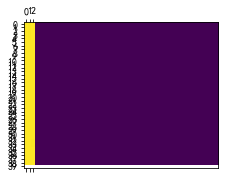

In [94]:
translate("'<start> you are lucky <end>'", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")

In [ ]:
translate('<start> spreading the cost of their work over all users . <end>')

In [ ]:
translate('<start> The House of Representatives approved a similar package earlier this month ! <end>')

In [ ]:
translate('<start> Many companies seek reassurance that all is well by installing cyber-security tools to monitor employees ! <end>')